In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from tqdm import tqdm
from numpy.fft import fft, fftshift
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings(action='ignore')


#### Data loading

In [151]:
train=pd.read_csv('./data/train_features.csv')
train_labels=pd.read_csv('./data/train_labels.csv')
test=pd.read_csv('./data/test_features.csv')

submission=pd.read_csv('./data/sample_submission.csv')

pd.options.display.max_columns=50

#### Feature engneering

#####  가속도, 자이로, (자이로-가속도) 센서값을 에너지로 표현

In [152]:
train['acc_Energy']=(train['acc_x']**2+train['acc_y']**2+train['acc_z']**2)**(1/3)
test['acc_Energy']=(test['acc_x']**2+test['acc_y']**2+test['acc_z']**2)**(1/3)

train['gy_Energy']=(train['gy_x']**2+train['gy_y']**2+train['gy_z']**2)**(1/3)
test['gy_Energy']=(test['gy_x']**2+test['gy_y']**2+test['gy_z']**2)**(1/3)

train['gy_acc_Energy']=((train['gy_x']-train['acc_x'])**2+(train['gy_y']-train['acc_y'])**2+(train['gy_z']-train['acc_z'])**2)**(1/3)
test['gy_acc_Energy']=((test['gy_x']-test['acc_x'])**2+(test['gy_y']-test['acc_y'])**2+(test['gy_z']-test['acc_z'])**2)**(1/3)

###### id별 데이터는 0.02초마다 측정된 값들이기 때문에 이전 시간 대비 변화량 적용

In [153]:
dt=0.02 
def jerk_signal(signal): 
        return np.array([(signal[i+1]-signal[i])/dt for i in range(len(signal)-1)])

In [35]:
len(temp) - 1

599

In [43]:
temp

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_Energy,gy_Energy,gy_acc_Energy
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112,1.146962,12.465436,12.427938
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216,1.200703,12.913284,12.865692
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629,1.217403,13.725729,13.692643
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013,1.209981,15.374021,15.314907
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234,1.211254,16.074363,16.017964
...,...,...,...,...,...,...,...,...,...,...,...
595,0,595,0.985242,-0.326122,-0.354528,-14.903280,20.172339,22.973018,1.063469,10.497476,10.675966
596,0,596,1.052837,-0.220710,-0.413472,-10.857025,19.786856,23.174597,1.099211,10.152517,10.318246
597,0,597,1.025643,-0.227845,-0.354516,-2.334243,25.768654,18.932070,1.071307,10.092134,10.193175
598,0,598,1.031553,-0.387862,-0.277857,-9.710746,28.697694,20.631577,1.089077,11.034378,11.183082


In [39]:
temp.values[0]

array([  0.        ,   0.        ,   1.20608659,  -0.17937144,
        -0.14844666,  -0.59160785, -30.54900952, -31.67611187,
         1.14696246,  12.46543635,  12.427938  ])

In [42]:
(temp.values[1] - temp.values[0]) / 0.2

array([  0.        ,   5.        ,   0.40804946,  -0.09801141,
        -0.16998541,   4.4735403 , -42.95046766,  33.74447932,
         0.26870238,   2.23923579,   2.1887693 ])

In [64]:
# train.loc[train['id'] == 0]
temp = train.loc[train['id'] == 0]

# train.columns[2:]
v = train.columns[2:]

jerk_signal(temp[v].values)
values = jerk_signal(temp[v].values)
np.insert(values,0,0)      #0번 index에 0추가 후 1차원 array변환

array([ 0.        ,  4.08049463, -0.98011409, ...,  4.78098086,
       51.30505283, 53.34325901])

In [44]:
#jerk 가속도변화의 변화량

In [154]:
train_dt=[]
for i in tqdm(train['id'].unique()):
    temp=train.loc[train['id']==i]
    for v in train.columns[2:]:
        values=jerk_signal(temp[v].values)
        values=np.insert(values,0,0)
        temp.loc[:,v+'_dt']=values
    train_dt.append(temp)


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:58<00:00, 53.62it/s]


In [32]:
train_dt[0]

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_Energy,gy_Energy,gy_acc_Energy,acc_x_dt,acc_y_dt,acc_z_dt,gy_x_dt,gy_y_dt,gy_z_dt,acc_Energy_dt,gy_Energy_dt,gy_acc_Energy_dt
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112,1.146962,12.465436,12.427938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216,1.200703,12.913284,12.865692,4.080495,-0.980114,-1.699854,44.735403,-429.504677,337.444793,2.687024,22.392358,21.887693
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629,1.217403,13.725729,13.692643,0.845632,0.192961,-3.546937,-196.018888,-249.173073,-4.620631,0.835012,40.622253,41.347563
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013,1.209981,15.374021,15.314907,-0.575711,-1.762585,1.908626,316.513181,-473.763910,-121.719195,-0.371100,82.414636,81.113199
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234,1.211254,16.074363,16.017964,0.389598,2.130453,-0.365665,78.686055,-215.435892,-25.361098,0.063656,35.017060,35.152822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,595,0.985242,-0.326122,-0.354528,-14.903280,20.172339,22.973018,1.063469,10.497476,10.675966,1.177958,-4.242820,-0.324471,-220.368219,-286.214412,340.765651,1.494244,17.990525,19.714449
596,0,596,1.052837,-0.220710,-0.413472,-10.857025,19.786856,23.174597,1.099211,10.152517,10.318246,3.379771,5.270607,-2.947208,202.312749,-19.274131,10.078975,1.787111,-17.247953,-17.885963
597,0,597,1.025643,-0.227845,-0.354516,-2.334243,25.768654,18.932070,1.071307,10.092134,10.193175,-1.359731,-0.356764,2.947780,426.139108,299.089890,-212.126333,-1.395196,-3.019192,-6.253557
598,0,598,1.031553,-0.387862,-0.277857,-9.710746,28.697694,20.631577,1.089077,11.034378,11.183082,0.295512,-8.000850,3.832979,-368.825182,146.451989,84.975330,0.888507,47.112213,49.495340


In [69]:
# test_dt=[]
# for i in tqdm(test['id'].unique()):
#     temp=test.loc[test['id']==i]
#     for v in train.columns[2:]:
#         values=jerk_signal(temp[v].values)
#         values=np.insert(values,0,0)
#         temp.loc[:,v+'_dt']=values
#     test_dt.append(temp)

100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:11<00:00, 70.15it/s]


##### 가속도, 자이로 센서값들을 푸리에 변환

In [155]:
from scipy import fftpack
from numpy.fft import *

def fourier_transform_one_signal(t_signal):
    complex_f_signal= fftpack.fft(t_signal)
    amplitude_f_signal=np.abs(complex_f_signal)
    return amplitude_f_signal

In [156]:
train=pd.concat(train_dt)

In [82]:
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_Energy,gy_Energy,gy_acc_Energy,acc_x_dt,acc_y_dt,acc_z_dt,gy_x_dt,gy_y_dt,gy_z_dt,acc_Energy_dt,gy_Energy_dt,gy_acc_Energy_dt
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112,1.146962,12.465436,12.427938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216,1.200703,12.913284,12.865692,4.080495,-0.980114,-1.699854,44.735403,-429.504677,337.444793,2.687024,22.392358,21.887693
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629,1.217403,13.725729,13.692643,0.845632,0.192961,-3.546937,-196.018888,-249.173073,-4.620631,0.835012,40.622253,41.347563
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013,1.209981,15.374021,15.314907,-0.575711,-1.762585,1.908626,316.513181,-473.763910,-121.719195,-0.371100,82.414636,81.113199
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234,1.211254,16.074363,16.017964,0.389598,2.130453,-0.365665,78.686055,-215.435892,-25.361098,0.063656,35.017060,35.152822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437,1.009050,25.963234,25.897316,1.484646,0.303666,0.800069,-150.644663,-34.630282,-8.380088,-0.679712,8.387109,8.432977
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087,1.002827,25.784692,25.722482,1.474659,-0.005442,1.775771,-39.061611,110.842743,-16.732496,-0.311171,-8.927089,-8.741727
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125,1.006239,25.628060,25.572145,0.915321,-0.407957,1.744566,113.799702,151.036858,-137.001896,0.170620,-7.831611,-7.516832
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478,1.001038,25.626266,25.573288,1.709833,-0.796984,0.479107,211.827245,-18.171144,-44.717652,-0.260074,-0.089713,0.057150


In [59]:
temp = train.loc[train['id'] == 1]

# temp['acc_x'].values

fourier_transform_one_signal(temp['acc_x'].values)

array([4.59948117e+02, 9.25608169e+01, 8.24514477e+01, 7.47521477e+01,
       1.25984057e+01, 2.32009942e+01, 3.38340045e+01, 3.57384381e+01,
       3.25181599e+01, 2.72695878e+01, 1.96043134e+01, 2.83065024e+01,
       7.10484054e+00, 4.64911870e+01, 1.22654171e+01, 4.03864326e+01,
       5.48711520e+01, 3.58434966e+01, 4.01096484e+01, 8.13353642e+00,
       2.26283263e+01, 1.50267859e+01, 5.73678985e+00, 6.75854211e+00,
       4.44425347e+00, 1.98479809e+01, 3.12689056e+01, 1.97452495e+01,
       2.45438786e+00, 1.87215449e+01, 1.87444878e+01, 8.05689547e+00,
       1.24566504e+01, 1.45357274e+01, 5.90177056e+00, 4.41989314e+00,
       1.31966168e+01, 7.55829445e+00, 1.43144487e+01, 6.82121259e+00,
       8.31921374e+00, 1.54774677e+01, 6.33143922e+00, 8.58947597e+00,
       5.85265922e+00, 5.56930207e+00, 2.05894082e+00, 3.91629216e+00,
       3.86496940e+00, 4.19078597e+00, 1.33517384e+01, 1.12939306e+01,
       5.07096790e+00, 5.26580172e+00, 2.28906958e+00, 4.35318126e+00,
      

In [157]:
fft=[]
for i in tqdm(train['id'].unique()):
    temp=train.loc[train['id']==i]
    for i in train.columns[2:8]:
        temp[i]=fourier_transform_one_signal(temp[i].values)
    fft.append(temp)

100%|█████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:13<00:00, 235.98it/s]


In [158]:
fft_train=pd.concat(fft)

In [73]:
# test=pd.concat(test_dt)

In [74]:
# fft_t=[]
# for i in tqdm(test['id'].unique()):
#     temp=test.loc[test['id']==i]
#     for i in test.columns[2:8]:
#         temp[i]=fourier_transform_one_signal(temp[i].values)
#     fft_t.append(temp)
# test=pd.concat(fft_t)

100%|███████████████████████████████████████████████████████████████████████████████| 782/782 [00:01<00:00, 421.48it/s]


In [85]:
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_Energy,gy_Energy,gy_acc_Energy,acc_x_dt,acc_y_dt,acc_z_dt,gy_x_dt,gy_y_dt,gy_z_dt,acc_Energy_dt,gy_Energy_dt,gy_acc_Energy_dt
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112,1.146962,12.465436,12.427938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216,1.200703,12.913284,12.865692,4.080495,-0.980114,-1.699854,44.735403,-429.504677,337.444793,2.687024,22.392358,21.887693
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629,1.217403,13.725729,13.692643,0.845632,0.192961,-3.546937,-196.018888,-249.173073,-4.620631,0.835012,40.622253,41.347563
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013,1.209981,15.374021,15.314907,-0.575711,-1.762585,1.908626,316.513181,-473.763910,-121.719195,-0.371100,82.414636,81.113199
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234,1.211254,16.074363,16.017964,0.389598,2.130453,-0.365665,78.686055,-215.435892,-25.361098,0.063656,35.017060,35.152822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437,1.009050,25.963234,25.897316,1.484646,0.303666,0.800069,-150.644663,-34.630282,-8.380088,-0.679712,8.387109,8.432977
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087,1.002827,25.784692,25.722482,1.474659,-0.005442,1.775771,-39.061611,110.842743,-16.732496,-0.311171,-8.927089,-8.741727
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125,1.006239,25.628060,25.572145,0.915321,-0.407957,1.744566,113.799702,151.036858,-137.001896,0.170620,-7.831611,-7.516832
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478,1.001038,25.626266,25.573288,1.709833,-0.796984,0.479107,211.827245,-18.171144,-44.717652,-0.260074,-0.089713,0.057150


In [159]:
before_train = train.iloc[:, :8].values
before_train

array([[ 0.00000000e+00,  0.00000000e+00,  1.20608659e+00, ...,
        -5.91607848e-01, -3.05490095e+01, -3.16761119e+01],
       [ 0.00000000e+00,  1.00000000e+00,  1.28769648e+00, ...,
         3.03100213e-01, -3.91391031e+01, -2.49272160e+01],
       [ 0.00000000e+00,  2.00000000e+00,  1.30460912e+00, ...,
        -3.61727754e+00, -4.41225645e+01, -2.50196286e+01],
       ...,
       [ 3.12400000e+03,  5.97000000e+02, -6.64730300e-01, ...,
        -2.78730951e+01, -9.87760722e+01, -7.93651247e+01],
       [ 3.12400000e+03,  5.98000000e+02, -6.30533630e-01, ...,
        -2.36365502e+01, -9.91394951e+01, -8.02594777e+01],
       [ 3.12400000e+03,  5.99000000e+02, -5.78351314e-01, ...,
        -1.79176259e+01, -1.00181873e+02, -8.06762295e+01]])

In [160]:
column_lst = ['id', 'time']
for i in train.columns[2:8]:
    column_lst.append('before_'+i)
column_lst

['id',
 'time',
 'before_acc_x',
 'before_acc_y',
 'before_acc_z',
 'before_gy_x',
 'before_gy_y',
 'before_gy_z']

In [161]:
df = pd.DataFrame(before_train, columns=column_lst)
before_train = df.astype({'id':'int64', 'time':'int64'})

In [164]:
df = pd.DataFrame()
df = before_train.merge(fft_train, how='left', on=['id', 'time'])

In [165]:
df

,id,time,before_acc_x,before_acc_y,before_acc_z,before_gy_x,before_gy_y,before_gy_z,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_Energy,gy_Energy,gy_acc_Energy,acc_x_dt,acc_y_dt,acc_z_dt,gy_x_dt,gy_y_dt,gy_z_dt,acc_Energy_dt,gy_Energy_dt,gy_acc_Energy_dt
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112,558.797337,131.082711,222.252919,1119.161589,2015.703683,709.264425,1.146962,12.465436,12.427938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216,3.233175,15.689279,12.229014,221.599635,361.903330,477.080942,1.200703,12.913284,12.865692,4.080495,-0.980114,-1.699854,44.735403,-429.504677,337.444793,2.687024,22.392358,21.887693
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629,4.832535,8.199566,3.901211,357.200415,430.568986,452.096143,1.217403,13.725729,13.692643,0.845632,0.192961,-3.546937,-196.018888,-249.173073,-4.620631,0.835012,40.622253,41.347563
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013,5.675383,5.330015,2.527445,340.433376,787.558320,467.307109,1.209981,15.374021,15.314907,-0.575711,-1.762585,1.908626,316.513181,-473.763910,-121.719195,-0.371100,82.414636,81.113199
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234,7.415275,7.980024,6.566908,128.188871,1372.095224,715.824074,1.211254,16.074363,16.017964,0.389598,2.130453,-0.365665,78.686055,-215.435892,-25.361098,0.063656,35.017060,35.152822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437,11.743654,3.796333,12.513870,715.873677,1124.494889,645.627066,1.009050,25.963234,25.897316,1.484646,0.303666,0.800069,-150.644663,-34.630282,-8.380088,-0.679712,8.387109,8.432977
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087,211.498089,82.888508,86.807874,5515.261695,28917.564390,20218.747027,1.002827,25.784692,25.722482,1.474659,-0.005442,1.775771,-39.061611,110.842743,-16.732496,-0.311171,-8.927089,-8.741727
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125,12.175349,6.200258,2.084554,343.695161,464.375112,78.097163,1.006239,25.628060,25.572145,0.915321,-0.407957,1.744566,113.799702,151.036858,-137.001896,0.170620,-7.831611,-7.516832
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478,19.116783,3.830800,6.938661,791.376179,2724.373764,1131.590078,1.001038,25.626266,25.573288,1.709833,-0.796984,0.479107,211.827245,-18.171144,-44.717652,-0.260074,-0.089713,0.057150


In [183]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler = StandardScaler()
scaler.fit(df.iloc[:, 2:])
scaled_data = scaler.transform(df.iloc[:, 2:])

df.iloc[:, 2:] = scaled_data

,id,time,before_acc_x,before_acc_y,before_acc_z,before_gy_x,before_gy_y,before_gy_z,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_Energy,gy_Energy,gy_acc_Energy,acc_x_dt,acc_y_dt,acc_z_dt,gy_x_dt,gy_y_dt,gy_z_dt,acc_Energy_dt,gy_Energy_dt,gy_acc_Energy_dt
0,0,0,2.307314,-0.029939,-0.432104,0.011776,-0.410859,-0.461007,27.356382,8.807207,19.465910,0.376992,0.869226,0.150423,0.495681,-0.272719,-0.276391,0.000027,0.000298,-0.000433,0.000347,0.000373,0.000273,0.000101,0.001505,0.001501
1,0,1,2.421086,-0.063321,-0.504058,0.026484,-0.528052,-0.365459,-0.054866,0.833464,0.820412,-0.282128,-0.093560,0.011266,0.742974,-0.236152,-0.240632,0.416836,-0.118821,-0.255054,0.032738,-0.349095,0.377085,0.564992,0.166566,0.162871
2,0,2,2.444664,-0.056749,-0.654199,-0.037962,-0.596041,-0.366767,0.024046,0.315921,0.081086,-0.182551,-0.053585,-0.003708,0.819822,-0.169815,-0.173080,0.086405,0.023750,-0.531727,-0.141582,-0.202368,-0.004887,0.175645,0.300944,0.306341
3,0,3,2.428612,-0.116782,-0.573407,0.066099,-0.725311,-0.401232,0.065632,0.117634,-0.040874,-0.194863,0.154242,0.005408,0.785669,-0.035229,-0.040560,-0.058780,-0.213920,0.285459,0.229520,-0.385106,-0.135647,-0.077915,0.609008,0.599518
4,0,4,2.439475,-0.044220,-0.588886,0.091969,-0.784094,-0.408413,0.151477,0.300751,0.317742,-0.350724,0.494539,0.154354,0.791528,0.021954,0.016872,0.039823,0.259227,-0.055206,0.057320,-0.174917,-0.028047,0.013483,0.259626,0.260669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.367432,-0.845648,0.503707,-0.461266,-1.413128,-1.092639,0.365037,0.011656,0.845701,0.080839,0.350395,0.112282,-0.138940,0.829394,0.823900,0.151679,0.037205,0.119409,-0.108728,-0.027804,-0.009085,-0.142794,0.063329,0.063674
1874996,3124,596,-0.326315,-0.845833,0.578875,-0.474109,-1.382884,-1.097377,10.220817,5.476964,7.441373,3.605246,16.530576,11.843241,-0.167578,0.814816,0.809618,0.150658,-0.000363,0.265559,-0.027936,0.090560,-0.018412,-0.065316,-0.064300,-0.062949
1874997,3124,597,-0.300794,-0.859728,0.652722,-0.436694,-1.341672,-1.136169,0.386337,0.177768,-0.080193,-0.192468,-0.033904,-0.227861,-0.151875,0.802027,0.797338,0.093524,-0.049283,0.260884,0.082744,0.123264,-0.152712,0.035970,-0.056225,-0.053918
1874998,3124,598,-0.253120,-0.886873,0.673002,-0.367051,-1.346630,-1.148831,0.728823,0.014037,0.350745,0.136284,1.281790,0.403540,-0.175811,0.801880,0.797431,0.174681,-0.096564,0.071332,0.153722,-0.014412,-0.049662,-0.054574,0.000843,0.001922


<function matplotlib.pyplot.show(close=None, block=None)>

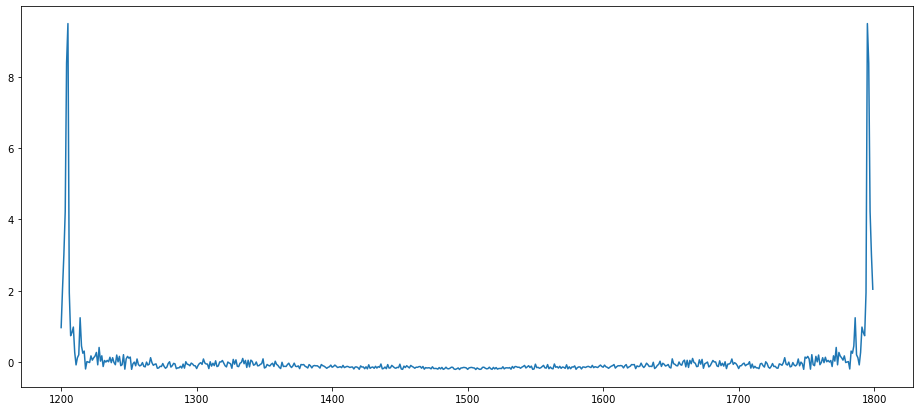

In [188]:
plt.figure(figsize=(16, 7))
# plt.plot(df[df['id']==2]['before_acc_x'])
plt.plot(df[df['id']==2]['acc_x'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

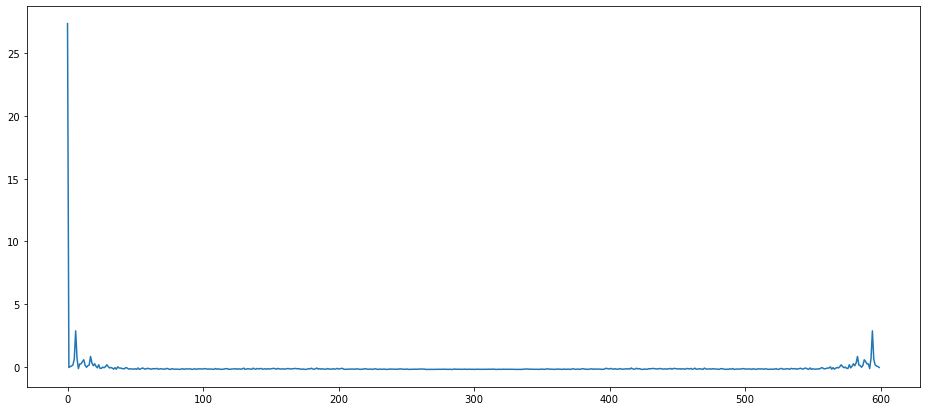

In [189]:
plt.figure(figsize=(16, 7))
# plt.plot(df[df['id']==0]['before_acc_x'])
plt.plot(df[df['id']==0]['acc_x'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

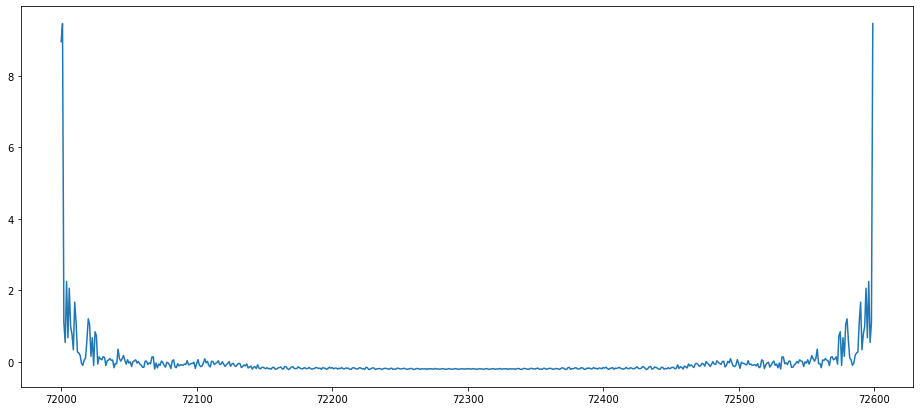

In [190]:
plt.figure(figsize=(16, 7))
plt.plot(df[df['id']==0]['before_acc_x'])
plt.plot(df[df['id']==120]['acc_x'])
plt.show

##### Standard scaling 적용


In [45]:
col=train.columns
train_s=train.copy()
test_s=test.copy()

In [46]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler = StandardScaler()

train_s.iloc[:,2:]= scaler.fit_transform(train_s.iloc[:,2:])
train_sc = pd.DataFrame(data = train_s,columns =col)

test_s.iloc[:,2:]= scaler.transform(test_s.iloc[:,2:])
test_sc = pd.DataFrame(data = test_s,columns =col)

In [47]:
train_sc

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_Energy,gy_Energy,gy_acc_Energy,acc_x_dt,acc_y_dt,acc_z_dt,gy_x_dt,gy_y_dt,gy_z_dt,acc_Energy_dt,gy_Energy_dt,gy_acc_Energy_dt
0,0,0,27.356382,8.807207,19.465910,0.376992,0.869226,0.150423,0.495681,-0.272719,-0.276391,0.000027,0.000298,-0.000433,0.000347,0.000373,0.000273,0.000101,0.001505,0.001501
1,0,1,-0.054866,0.833464,0.820412,-0.282128,-0.093560,0.011266,0.742974,-0.236152,-0.240632,0.416836,-0.118821,-0.255054,0.032738,-0.349095,0.377085,0.564992,0.166566,0.162871
2,0,2,0.024046,0.315921,0.081086,-0.182551,-0.053585,-0.003708,0.819822,-0.169815,-0.173080,0.086405,0.023750,-0.531727,-0.141582,-0.202368,-0.004887,0.175645,0.300944,0.306341
3,0,3,0.065632,0.117634,-0.040874,-0.194863,0.154242,0.005408,0.785669,-0.035229,-0.040560,-0.058780,-0.213920,0.285459,0.229520,-0.385106,-0.135647,-0.077915,0.609008,0.599518
4,0,4,0.151477,0.300751,0.317742,-0.350724,0.494539,0.154354,0.791528,0.021954,0.016872,0.039823,0.259227,-0.055206,0.057320,-0.174917,-0.028047,0.013483,0.259626,0.260669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874995,3124,595,0.365037,0.011656,0.845701,0.080839,0.350395,0.112282,-0.138940,0.829394,0.823900,0.151679,0.037205,0.119409,-0.108728,-0.027804,-0.009085,-0.142794,0.063329,0.063674
1874996,3124,596,10.220817,5.476964,7.441373,3.605246,16.530576,11.843241,-0.167578,0.814816,0.809618,0.150658,-0.000363,0.265559,-0.027936,0.090560,-0.018412,-0.065316,-0.064300,-0.062949
1874997,3124,597,0.386337,0.177768,-0.080193,-0.192468,-0.033904,-0.227861,-0.151875,0.802027,0.797338,0.093524,-0.049283,0.260884,0.082744,0.123264,-0.152712,0.035970,-0.056225,-0.053918
1874998,3124,598,0.728823,0.014037,0.350745,0.136284,1.281790,0.403540,-0.175811,0.801880,0.797431,0.174681,-0.096564,0.071332,0.153722,-0.014412,-0.049662,-0.054574,0.000843,0.001922


##### 모델링

+ CNN, LSTM, CNN+LSTM 등 여러 구조 적용해보다가 CNN에서 Flatten 없이 Global average pooling 한 구조가 가장 성능이 좋아 채택했습니다.


In [48]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
from keras.models import Sequential
from keras.layers import Dense, LSTM,Bidirectional,Dropout
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from keras import backend as K 
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from sklearn.model_selection import KFold,StratifiedKFold
from numpy.random import seed
import keras

In [49]:
X=np.array(train_sc.iloc[:,2:]).reshape(3125, 600, -1)
X.shape

(3125, 600, 18)

In [50]:
test_x=np.array(test_sc.iloc[:,2:]).reshape(782, 600, -1)
test_x.shape

(782, 600, 18)

In [51]:
y = train_labels['label'].values
y = tf.keras.utils.to_categorical(train_labels['label']) 
y.shape

(3125, 61)

##### 모델 구조 

In [52]:
def cnn_model(input_shape, classes):
    seed(2021)
    tf.random.set_seed(2021)
    
    input_layer = keras.layers.Input(input_shape)
    conv1 = keras.layers.Conv1D(filters=128, kernel_size=9, padding='same')(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)
    conv1 = keras.layers.Dropout(rate=0.3)(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=6, padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)
    conv2 = keras.layers.Dropout(rate=0.4)(conv2)
    
    conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)
    conv3 = keras.layers.Dropout(rate=0.5)(conv3)
    
    gap = keras.layers.GlobalAveragePooling1D()(conv3)
    
    output_layer = keras.layers.Dense(classes, activation='softmax')(gap)
    
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(), 
        metrics=['accuracy'])
    
    return model

##### 10-fold StratifiedKFold

In [53]:
skf = StratifiedKFold(n_splits = 10, random_state = 2021, shuffle = True)
reLR = ReduceLROnPlateau(patience = 4,verbose = 1,factor = 0.5) 
es =EarlyStopping(monitor='val_loss', patience=8, mode='min')

accuracy = []
losss=[]
models=[]

for i, (train, validation) in enumerate(skf.split(X, y.argmax(1))) :
    mc = ModelCheckpoint(f'./model_kf/cv_study{i + 1}.h5',save_best_only=True, verbose=0, monitor = 'val_loss', mode = 'min', save_weights_only=True)
    print("-" * 20 +"Fold_"+str(i+1)+ "-" * 20)
    model = cnn_model((600,18),61)
    history = model.fit(X[train], y[train], epochs = 100, validation_data= (X[validation], y[validation]), 
                        verbose=1,batch_size=64,callbacks=[es,mc,reLR])
    model.load_weights(f'./model_kf/cv_study{i + 1}.h5')
    
    k_accuracy = '%.4f' % (model.evaluate(X[validation], y[validation])[1])
    k_loss = '%.4f' % (model.evaluate(X[validation], y[validation])[0])
    
    accuracy.append(k_accuracy)
    losss.append(k_loss)
    models.append(model)

print('\nK-fold cross validation Auc: {}'.format(accuracy))
print('\nK-fold cross validation loss: {}'.format(losss))

--------------------Fold_1--------------------
Epoch 1/100
44/44 [==============================] - 9s 185ms/step - loss: 3.3854 - accuracy: 0.3490 - val_loss: 3.1161 - val_accuracy: 0.3099
Epoch 2/100
44/44 [==============================] - 8s 185ms/step - loss: 1.9729 - accuracy: 0.5509 - val_loss: 1.9228 - val_accuracy: 0.5304
Epoch 3/100
44/44 [==============================] - 8s 185ms/step - loss: 1.7849 - accuracy: 0.5650 - val_loss: 2.0362 - val_accuracy: 0.5495
Epoch 4/100
44/44 [==============================] - 8s 184ms/step - loss: 1.5552 - accuracy: 0.6141 - val_loss: 1.9158 - val_accuracy: 0.5623
Epoch 5/100
44/44 [==============================] - 8s 184ms/step - loss: 1.3835 - accuracy: 0.6450 - val_loss: 1.5137 - val_accuracy: 0.6070
Epoch 6/100
44/44 [==============================] - 8s 184ms/step - loss: 1.2684 - accuracy: 0.6751 - val_loss: 1.4040 - val_accuracy: 0.6230
Epoch 7/100
44/44 [==============================] - 8s 183ms/step - loss: 1.1646 - accuracy: 0

##### 성능 확인 및 제출

In [54]:
print(sum([float(i) for i in accuracy])/10)
print()
print(sum([float(i) for i in losss])/10)

0.8528

0.48506


In [55]:
test_X=np.array(test_sc.iloc[:,2:]).reshape(782, 600, -1)
test_X.shape

(782, 600, 18)

In [56]:
preds = []
for model in models:
    pred = model.predict(test_X)
    preds.append(pred)
pred = np.mean(preds, axis=0)
pred

array([[1.11362115e-05, 2.25996450e-06, 2.11680984e-07, ...,
        6.39248919e-03, 1.50766409e-05, 3.40101496e-06],
       [4.13231173e-04, 1.99007154e-05, 1.22563812e-04, ...,
        8.93750075e-06, 2.06302539e-05, 1.22722922e-05],
       [1.86802447e-03, 3.26019563e-02, 1.62000761e-05, ...,
        8.92708835e-04, 1.20446784e-02, 2.22884724e-03],
       ...,
       [4.16979339e-04, 3.25313522e-06, 1.09946477e-05, ...,
        1.80470997e-05, 1.36069389e-06, 7.54901499e-04],
       [3.85870408e-06, 8.71700991e-04, 9.34987668e-07, ...,
        1.06083007e-07, 1.25161705e-05, 4.91666885e-09],
       [9.32284092e-05, 4.08958658e-06, 1.09709674e-06, ...,
        9.87853055e-05, 9.04675460e-07, 1.53993984e-04]], dtype=float32)

In [57]:
submission=pd.read_csv('./data/sample_submission.csv')
submission.iloc[:,1:]=pred
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,...,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0.000011,0.000002,2.116810e-07,4.708937e-08,1.865657e-04,1.124369e-07,3.247155e-04,0.000002,1.424222e-07,0.005938,0.100756,4.794668e-01,1.128225e-04,3.902865e-01,2.294270e-03,3.994864e-06,2.203607e-06,7.347716e-07,4.205005e-07,9.210566e-08,3.008443e-05,0.000004,7.120603e-07,0.005244,...,0.001091,9.638647e-04,0.000089,1.705775e-05,2.177705e-07,6.212062e-09,0.000386,0.000093,3.137485e-05,8.554223e-04,3.529570e-05,1.155294e-07,3.284435e-06,2.174506e-06,3.665759e-08,4.478506e-04,4.650679e-04,1.211206e-05,2.320302e-06,1.255611e-07,2.459125e-07,8.899527e-10,6.392489e-03,1.507664e-05,3.401015e-06
1,3126,0.000413,0.000020,1.225638e-04,1.330648e-03,5.290742e-05,6.115026e-04,2.825133e-06,0.000066,7.107466e-06,0.000011,0.000024,1.578770e-06,1.445539e-08,2.135061e-06,1.027968e-06,2.940293e-04,2.704988e-05,1.144425e-05,2.083481e-05,4.048173e-06,2.643172e-05,0.000180,2.340468e-03,0.000217,...,0.000310,4.793614e-06,0.000002,3.656085e-08,4.648645e-04,3.747970e-04,0.000015,0.000007,1.712846e-06,4.472250e-06,8.808629e-06,1.643756e-05,1.192999e-04,2.324675e-03,6.748711e-04,7.841913e-06,1.797475e-08,9.208373e-05,1.928369e-04,1.234607e-04,4.037772e-06,1.639472e-04,8.937501e-06,2.063025e-05,1.227229e-05
2,3127,0.001868,0.032602,1.620008e-05,1.283705e-05,3.405659e-05,6.504179e-04,1.054489e-01,0.000152,1.890009e-05,0.000041,0.002011,4.135342e-04,3.376489e-05,2.495863e-03,1.967650e-02,8.969253e-04,1.574834e-04,1.690211e-04,4.927005e-05,2.873521e-04,2.336423e-04,0.000258,5.826922e-07,0.000569,...,0.000390,4.887589e-02,0.006375,3.705476e-04,2.303389e-04,1.743668e-04,0.063292,0.195926,7.786207e-03,4.333588e-01,2.320479e-04,2.547552e-03,2.427308e-03,4.264420e-03,3.207233e-06,4.141561e-05,2.466323e-05,1.434178e-06,8.685702e-04,1.100743e-06,3.044588e-03,6.567472e-08,8.927088e-04,1.204468e-02,2.228847e-03
3,3128,0.000691,0.000010,3.345231e-05,1.176274e-04,1.757207e-05,1.440693e-04,5.411918e-06,0.000118,1.369785e-03,0.000056,0.000156,1.052319e-04,2.757647e-06,2.441343e-06,1.215714e-05,7.255679e-04,1.776193e-06,4.248767e-06,1.051885e-05,8.755162e-06,5.609869e-06,0.000086,1.119547e-04,0.000133,...,0.000285,2.999797e-06,0.000039,1.534645e-06,1.452966e-05,1.911514e-05,0.000014,0.000024,2.528368e-05,4.395631e-05,1.043876e-05,6.607959e-05,3.738505e-03,8.310549e-03,6.330538e-04,1.585062e-04,5.253386e-06,2.855355e-05,1.086101e-04,3.191976e-05,3.284602e-06,5.761672e-05,2.509627e-05,5.781790e-06,7.223898e-03
4,3129,0.004222,0.000031,2.595292e-06,2.950884e-04,2.631509e-04,2.281394e-05,7.910090e-07,0.000003,2.282780e-05,0.000076,0.000025,6.662969e-06,1.271762e-06,3.870370e-07,1.917479e-05,4.299077e-04,9.659639e-06,2.665155e-06,5.571738e-05,2.121639e-06,4.022555e-06,0.000007,3.395142e-04,0.000008,...,0.000016,4.269365e-07,0.000011,5.161713e-06,6.367538e-07,5.421267e-06,0.000096,0.000048,8.105874e-08,1.194872e-06,3.231482e-06,9.941075e-07,3.176446e-04,9.502537e-04,5.820632e-04,5.014890e-06,8.111192e-07,1.425431e-05,2.082707e-06,2.616074e-06,4.458506e-07,2.302143e-03,8.492467e-05,2.439178e-06,3.807932e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0.007722,0.000045,2.692790e-07,1.392818e-04,3.632546e-04,3.666391e-05,2.516073e-07,0.000004,5.034942e-05,0.000009,0.000006,5.608847e-07,8.443988e-08,4.424959e-08,3.241649e-06,5.664256e-04,1.966830e-05,4.358430e-06,1.377685e-04,1.753900e-06,9.672356e-07,0.000002,2.599161e-04,0.000001,...,0.000004,1.128838e-07,0.000002,2.651635e-07,1.488061e-06,1.090116e-05,0.000015,0.000004,8.845261e-08,5.673692e-07,2.185301e-06,7.444148e-07,2.017738e-04,3.374573e-04,1.702022e-03,2.183509e-07,3.351120e-08,2.855817e-06,4.701814e-07,2.122393e-07,2.414436e-07,1.602291e-02,2.339808e-05,2.259146e-06,5.595793e-03
778,3903,0.000128,0.0

In [30]:
submission.to_csv('sub_kfold_stratified_10_adam_fft_0.5.csv',index=False)